In [1]:
#import 库
from src import detect_faces, show_bboxes
from PIL import Image
import PIL
import os, sys, stat
import glob
import torch
import torch.utils.data as Data
from torchvision import datasets, models, transforms
import torchvision
import time
from torch.utils.data import DataLoader,Dataset
import numpy as np 
from torchvision import transforms
from torch.autograd import Variable
from src.get_nets import PNet, RNet, ONet # TODO
from src.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square,_preprocess,correct_bboxes
from src.first_stage import run_first_stage
from skimage import io,transform
#import tqdm
import math
from PIL import ImageDraw
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
def my_show_bboxes(img, bounding_boxes, facial_landmarks=[]):
    """Draw bounding boxes and facial landmarks.
    Arguments:
        img: an instance of PIL.Image.
        bounding_boxes: a float numpy array of shape [n, 5].
        facial_landmarks: a float numpy array of shape [n, 10].
    Returns:
        an instance of PIL.Image.
    """

    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    #plt.imshow(img_copy)
    print("???")
    for b in bounding_boxes:
        draw.rectangle([
            (b[0], b[1]), (b[2], b[3])
        ], outline='white')

    for p in facial_landmarks:
        for i in range(5):
            draw.ellipse([
                (p[i] - 1.0, p[i + 5] - 1.0),
                (p[i] + 1.0, p[i + 5] + 1.0)
            ], outline='blue')

    return img_copy

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    #print(inp)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    #print(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
def _generate_bboxes(probs, offsets, scale, threshold):
    """Generate bounding boxes at places
    where there is probably a face.
    Arguments:
        probs: a float numpy array of shape [n, m].
        offsets: a float numpy array of shape [1, 4, n, m].
        scale: a float number,
            width and height of the image were scaled by this number.
        threshold: a float number.
    Returns:
        a float numpy array of shape [n_boxes, 9]
    """

    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12

    # indices of boxes where there is probably a face
    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])

    # transformations of bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # they are defined as:
    # w = x2 - x1 + 1
    # h = y2 - y1 + 1
    # x1_true = x1 + tx1*w
    # x2_true = x2 + tx2*w
    # y1_true = y1 + ty1*h
    # y2_true = y2 + ty2*h

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    # P-Net is applied to scaled images
    # so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])
    # why one is added?

    return bounding_boxes.T

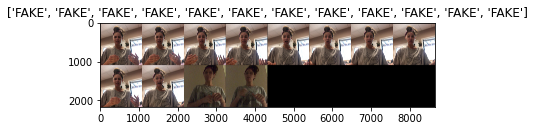

In [5]:
#dataset和dataloader
tf=transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize(1080),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data = datasets.ImageFolder("/data2/pbw_dfdc/experiment_1/discrete/train/",tf)#初始化类，设置数据集所在路径以及变换
workers = 2
class_names = data.classes
batch_size=12
dataloaders = DataLoader(data,batch_size,shuffle=False,num_workers=workers,pin_memory=False)#使用DataLoader加载数据
inputs, classes = next(iter(dataloaders))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
#@profile
def my_run_first_stage(pic, net, scale, threshold):
    """Run P-Net, generate bounding boxes, and do NMS.
    Arguments:
        image: an instance of PIL.Image.
        net: an instance of pytorch's nn.Module, P-Net.
        scale: a float number,
            scale width and height of the image by this number.
        threshold: a float number,
            threshold on the probability of a face when generating
            bounding boxes from predictions of the net.
    Returns:
        a float numpy array of shape [n_boxes, 9],
            bounding boxes with scores and offsets (4 + 1 + 4).
    """

    # scale the image and convert it to a float array
    boxes_list=[] # 32个人的list
    new_list=[]
    # pnet=PNet()
    # net=pnet
    # scale=0.6
    # threshold=0.6
    for i in range(batch_size):
        #print(type(pic))
        a=torch.squeeze(torch.chunk(pic,batch_size)[i])
        #a=torchvision.transforms.Normalize([-2.1179,-2.0357,-1.8044],[4.3668,4.4643,4.4444])(a)
        image=transforms.ToPILImage()(a)
        #print(np.asarray(pic))
        width, height = image.size
        sw, sh = math.ceil(width*scale), math.ceil(height*scale)
        img = image.resize((sw, sh), Image.BILINEAR)
        img.show()
        #print(img)
        img = np.asarray(img, 'float32')
        #print(img)
        img = Variable(torch.FloatTensor(_preprocess(img)), volatile=False)
        #print(img.shape)
        new_list.append(img)
    img=torch.cat(new_list)
    #img_cpu=img
    #print(img.shape)
    img=img.to(device)
    #print(img.shape)
    #print(img)
    since=time.time()
    output = net(img)
    #print(time.time()-since)
    output_0=output[0]
    output_1=output[1]
    #print(output_0.shape)
    #print(output_1.shape)
    #print(output_0)
    #print("1",output_1.shape)
    #print("0",output[0].shape)
    probs_list=[]
    offsets_list=[]
    for i in range(batch_size):
        #print(output_1[i].unsqueeze(0).shape)
        probs = output_1[i].unsqueeze(0).cpu().data.numpy()[0, 1, :, :]
        #print("probs.shape",probs.shape)
        
        probs_list.append(probs)
        offsets = output_0[i].unsqueeze(0).cpu().data.numpy()
        #offsets=offsets.unsqueeze(0)
        #print("offsets.shape",offsets.shape)
        offsets_list.append(offsets)
    #print(len(offsets_list))

    #print("2",offsets_list[0].shape)
    # probs: probability of a face at each sliding window
    # offsets: transformations to true bounding boxes

    for i in range(batch_size):
        #print(probs_list[i].shape)
        #print(offsets_list[i].shape)
        #print(scale)
        #print(threshold)
        boxes = _my_generate_bboxes(probs_list[i], offsets_list[i], scale, threshold)
        #print(boxes.shape)
        #print(type(boxes))
        if len(boxes) == 0:
            boxes_list.append(None)
            continue
        keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
        a=boxes[keep]
        boxes_list.append(a)
    #print(boxes[keep].shape)

    return boxes_list
def _my_generate_bboxes(probs, offsets, scale, threshold):
    """Generate bounding boxes at places
    where there is probably a face.

    Arguments:
        probs: a float numpy array of shape [n, m].
        offsets: a float numpy array of shape [1, 4, n, m].
        scale: a float number,
            width and height of the image were scaled by this number.
        threshold: a float number.

    Returns:
        a float numpy array of shape [n_boxes, 9]
    """

    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12
    #print(probs.shape)
    # indices of boxes where there is probably a face
    inds = np.where(probs > threshold)
    #print(inds)
    if inds[0].size == 0:
        return np.array([])

    # transformations of bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # they are defined as:
    # w = x2 - x1 + 1
    # h = y2 - y1 + 1
    # x1_true = x1 + tx1*w
    # x2_true = x2 + tx2*w
    # y1_true = y1 + ty1*h
    # y2_true = y2 + ty2*h

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    # P-Net is applied to scaled images
    # so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])
    # why one is added?

    return bounding_boxes.T

In [7]:
#first_stage
min_face_size=15.0
thresholds=[0.6, 0.7, 0.8]
#thresholds=[0.96,0.7,0.8]
nms_thresholds=[0.7, 0.7, 0.7]
"""
Arguments:
    image: an instance of PIL.Image.
    min_face_size: a float number.
    thresholds: a list of length 3.
    nms_thresholds: a list of length 3.
Returns:
    two float numpy arrays of shapes [n_boxes, 4] and [n_boxes, 10],
    bounding boxes and facial landmarks.
"""

# LOAD MODELS
pnet = PNet()
rnet = RNet()
onet = ONet()
onet.eval()

pnet = pnet.to(device)
rnet = rnet.to(device)
onet = onet.to(device)

# BUILD AN IMAGE PYRAMID
width, height = inputs.shape[2],inputs.shape[3]
min_length = min(height, width)
#print(width)
#print(height)
min_detection_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that
# minimum size that we can detect equals to
# minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
    scales.append(m*factor**factor_count)
    min_length *= factor
    factor_count += 1

print('scales:', ['{:.2f}'.format(s) for s in scales])
print('number of different scales:', len(scales))



scales: ['0.80', '0.57', '0.40', '0.28', '0.20', '0.14', '0.10', '0.07', '0.05', '0.04', '0.02', '0.02', '0.01']
number of different scales: 13


In [8]:
# STAGE 1

# it will be returned
bounding_boxes = []

# run P-Net on different scales
bounding_boxes_list=[]
for i in range(batch_size):
    bounding_boxes_list.append([])
#p_list=[]
for s in scales:
    #print(type(inputs))
    #pic=inputs
    #img=my_run_first_stage(inputs, pnet, scale=s, threshold=thresholds[0])
    boxes = my_run_first_stage(inputs, pnet, scale=s, threshold=thresholds[0])
    #print(len(boxes))
    for i in range(batch_size):
        bounding_boxes_list[i].append(boxes[i])
    #p_list.append(img)
# img=p_list[0]
# img=img[0]
# imshow(img)
#print(len(bounding_boxes_list))
#for i in bounding_boxes_list[0]:
    #print(i.shape)

#print(len(bounding_boxes_list))

# collect boxes (and offsets, and scores) from different scales
#bounding_boxes = [i for i in bounding_boxes if i is not None]

/home/pbw/mtcnn/src/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


In [9]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:

new_bboxes_list=[]
for bounding_boxes in bounding_boxes_list:
    bounding_boxes = [i for i in bounding_boxes if i is not None]
    bounding_boxes = np.vstack(bounding_boxes)
    
    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]
    # use offsets predicted by pnet to transform bounding boxes
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    # shape [n_boxes, 5]

    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    #print(bounding_boxes.shape)
    new_bboxes_list.append(bounding_boxes)
bounding_boxes_list.clear()
bounding_boxes_list=new_bboxes_list
list_x=[]
for bounding_boxes in bounding_boxes_list:
    #print(bounding_boxes.shape)
    list_x.append(len(bounding_boxes))
    pass
print(list_x)

[230, 254, 216, 198, 199, 199, 199, 175, 231, 184, 66, 65]


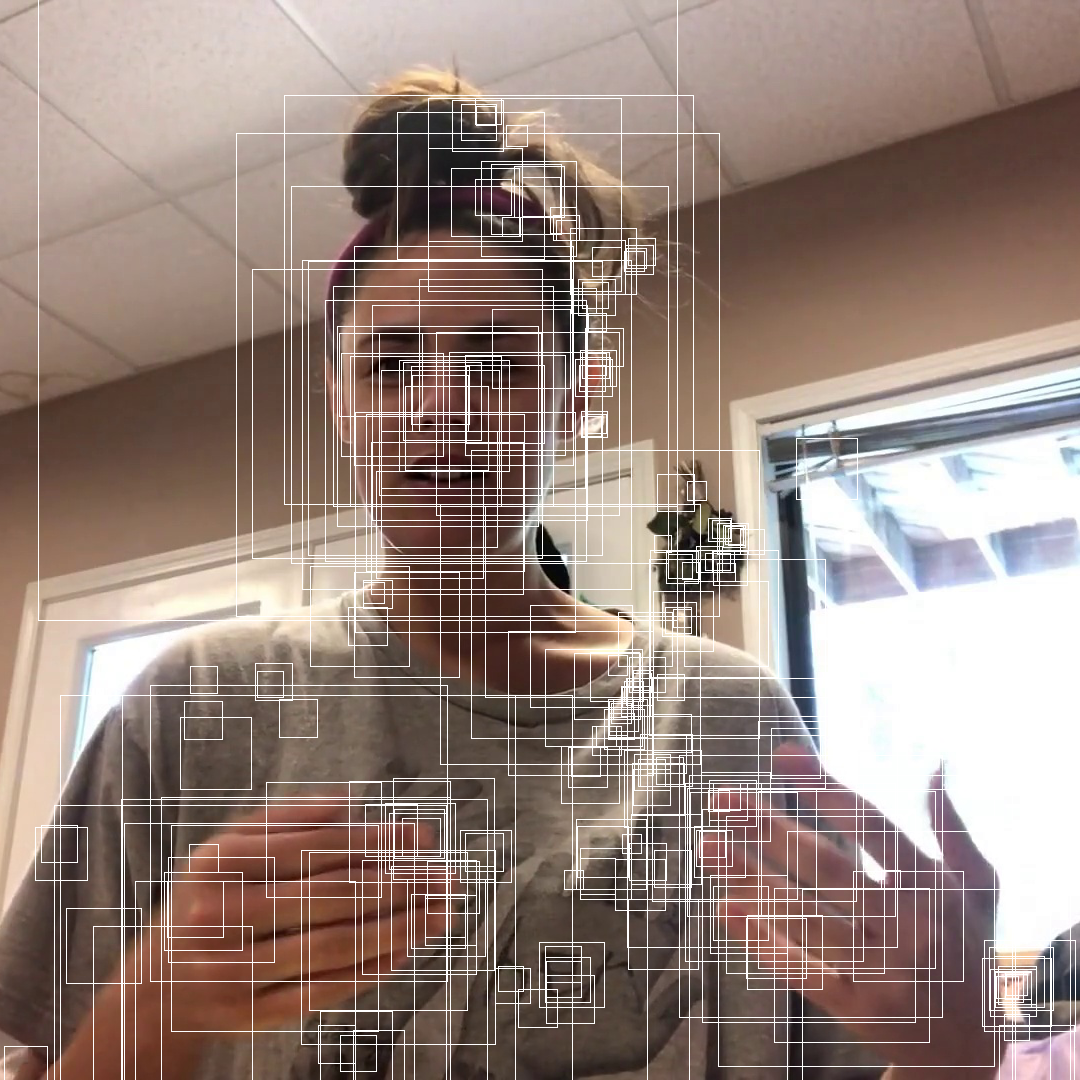

In [11]:
i=1
a=torch.squeeze(torch.chunk(inputs,batch_size)[i])
#a=torchvision.transforms.Normalize([-2.1179,-2.0357,-1.8044],[4.3668,4.4643,4.4444])(a)
tar_image=transforms.ToPILImage(mode='RGB')(a)
bbs=bounding_boxes_list[i]
show_bboxes(tar_image,bbs)

In [12]:
def my_get_image_boxes(bounding_boxes_list, pic, size=24):
    """Cut out boxes from the image.
    Arguments:
        bounding_boxes: a float numpy array of shape [n, 5].
        img: an instance of PIL.Image.
        size: an integer, size of cutouts.
    Returns:
        a float numpy array of shape [n, 3, size, size].
    """
    #size=24
    #pic=inputs
    img_boxes_list=[]
    for i in range(batch_size):
        bounding_boxes=bounding_boxes_list[i]
        #print(len(bounding_boxes))
        a=torch.squeeze(torch.chunk(pic,batch_size)[i])
        #a=torchvision.transforms.Normalize([-2.1179,-2.0357,-1.8044],[4.3668,4.4643,4.4444])(a)
        img=transforms.ToPILImage()(a)


        #img=image
        num_boxes = len(bounding_boxes)
        width, height = img.size

        [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
        img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')
        img_array = np.asarray(img, 'uint8')
        for i in range(num_boxes):
            img_box = np.zeros((h[i], w[i], 3), 'uint8')


            img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] =\
                img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

            # resize
            img_box = Image.fromarray(img_box)
            img_box = img_box.resize((size, size), Image.BILINEAR)
            img_box = np.asarray(img_box, 'float32')

            img_boxes[i, :, :, :] = _preprocess(img_box)

        img_boxes_list.append(img_boxes)

    return img_boxes_list

In [13]:
# STAGE 2
#print(bounding_boxes_list[0][6].shape)
img_boxes = my_get_image_boxes(bounding_boxes_list, inputs, size=24)

new_img_box_list=[]
for img_box in img_boxes:
    img_box = Variable(torch.FloatTensor(img_box), volatile=False)
    new_img_box_list.append(img_box)
img_boxes=torch.cat(new_img_box_list)
print(img_boxes.shape)
img_boxes=img_boxes.to(device)
output = rnet(img_boxes)

list_1=[]
list_2=[]
for o in torch.split(output[0],list_x):
    list_1.append(o.cpu().data.numpy())
    #print(o.shape)
for o in torch.split(output[1],list_x):
    list_2.append(o.cpu().data.numpy())
    #print(o.shape)
list_3=[]
for i in range(batch_size):
    offsets=list_1[i]
    probs=list_2[i]
    print(probs.shape)
    bounding_boxes=bounding_boxes_list[i]
    #offsets = output[0].data.numpy()  # shape [n_boxes, 4]
    #probs = output[1].data.numpy()  # shape [n_boxes, 2]
    print(bounding_boxes.shape)
    keep = np.where(probs[:, 1] > thresholds[1])[0]
    print("keep",keep)
    #print(bounding_boxes.shape)
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[1])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    list_3.append(bounding_boxes)
    print("bounding_boxes.shape",bounding_boxes.shape)
bounding_boxes_list=list_3


torch.Size([2216, 3, 24, 24])
(230, 2)
(230, 5)
keep [  0   1   2   3   9  11  26  36  39  44 121 186 191 200]
bounding_boxes.shape (11, 5)
(254, 2)
(254, 5)
keep [  0   1   2   3  10  14  18  69 135 163 182]
bounding_boxes.shape (9, 5)
(216, 2)
(216, 5)
keep [  0   1   2   3   6   7  15  23  87 159]
bounding_boxes.shape (8, 5)
(198, 2)
(198, 5)
keep [  0   1   3   4   5   7  26  37  89  91 100 103 114 155]
bounding_boxes.shape (12, 5)
(199, 2)
(199, 5)
keep [  0   1   3   5   6  11  12  13  15  16  17  71  72  82  85  87 101 151
 168]
bounding_boxes.shape (15, 5)
(199, 2)
(199, 5)
keep [  0   1   4   7   8  15  35  42  77  81  96 123]
bounding_boxes.shape (8, 5)
(199, 2)
(199, 5)
keep [  0   1   4   5   9  12  26  27  32  42  67  96 138]
bounding_boxes.shape (10, 5)
(175, 2)
(175, 5)
keep [  0   1   2   3  10  18  23  60 154 170]
bounding_boxes.shape (8, 5)
(231, 2)
(231, 5)
keep [  0   1   2   3   4   6   7  15  19  20  25 132 163 199 214]
bounding_boxes.shape (12, 5)
(184, 2)
(184, 

/home/pbw/mtcnn/src/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


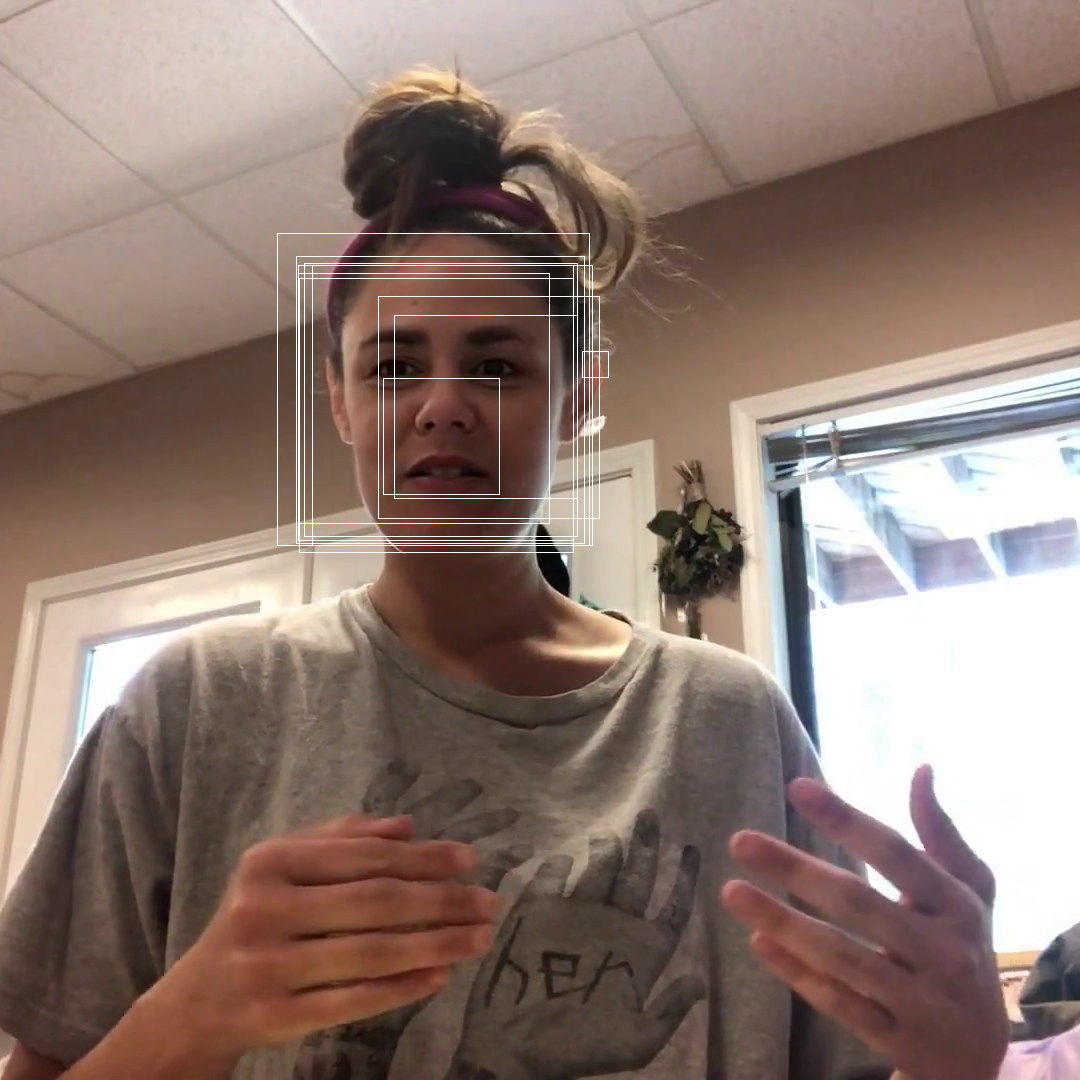

In [16]:
i=0
a=torch.squeeze(torch.chunk(inputs,batch_size)[i])
#a=torchvision.transforms.Normalize([-2.1179,-2.0357,-1.8044],[4.3668,4.4643,4.4444])(a)
tar_image=transforms.ToPILImage(mode='RGB')(a)
bbs=bounding_boxes_list[i]
show_bboxes(tar_image,bbs)

In [17]:
# STAGE 3
list_4=[]#返回结果的list
list_5=[]
list_11=[]
img_boxes_list = my_get_image_boxes(bounding_boxes_list, inputs, size=48)
for i in range(batch_size):
    img_boxes=img_boxes_list[i]
    print(img_boxes.shape)
    list_11.append(img_boxes.shape[0])
    if len(img_boxes) == 0: 
        list_4.append([])
        
        continue
    
    img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=False)
    list_5.append(img_boxes)
img_boxes=torch.cat(list_5)
img_boxes=img_boxes.to(device)

output = onet(img_boxes)
print(output[0].shape)
print(output[1].shape)
print(output[2].shape)




list_6=[]
list_7=[]
list_8=[]
for o in torch.split(output[0],list_11):
    list_6.append(o.cpu().data.numpy())
    print(o.shape)
for o in torch.split(output[1],list_11):
    list_7.append(o.cpu().data.numpy())
    print(o.shape)
for o in torch.split(output[2],list_11):
    list_8.append(o.cpu().data.numpy())
    #print(o.shape)


# landmarks = output[0].data.numpy()  # shape [n_boxes, 10]
# offsets = output[1].data.numpy()  # shape [n_boxes, 4]
# probs = output[2].data.numpy()  # shape [n_boxes, 2]
list_9=[]
list_10=[]
for i in range(batch_size):
    landmarks=list_6[i]
    offsets=list_7[i]
    probs=list_8[i]
    bounding_boxes=bounding_boxes_list[i]
    print(bounding_boxes.shape)
    
    print(probs)
    keep = np.where(probs[:, 1] > thresholds[2])[0]
    print(keep)
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]
    landmarks = landmarks[keep]

    # compute landmark points
    width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
    height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
    xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
    landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
    landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]

    bounding_boxes = calibrate_box(bounding_boxes, offsets)
    keep = nms(bounding_boxes, nms_thresholds[2], mode='min')
    bounding_boxes = bounding_boxes[keep]
    landmarks = landmarks[keep]
    list_9.append(bounding_boxes)
    list_10.append(landmarks)
print('number of bounding boxes:', len(list_9[0][0]))
bounding_boxes_list=list_9
#return bounding_boxes, landmarks

(11, 3, 48, 48)
(9, 3, 48, 48)
(8, 3, 48, 48)
(12, 3, 48, 48)
(15, 3, 48, 48)
(8, 3, 48, 48)
(10, 3, 48, 48)
(8, 3, 48, 48)
(12, 3, 48, 48)
(9, 3, 48, 48)
(4, 3, 48, 48)
(5, 3, 48, 48)
torch.Size([111, 10])
torch.Size([111, 4])
torch.Size([111, 2])
torch.Size([11, 10])
torch.Size([9, 10])
torch.Size([8, 10])
torch.Size([12, 10])
torch.Size([15, 10])
torch.Size([8, 10])
torch.Size([10, 10])
torch.Size([8, 10])
torch.Size([12, 10])
torch.Size([9, 10])
torch.Size([4, 10])
torch.Size([5, 10])
torch.Size([11, 4])
torch.Size([9, 4])
torch.Size([8, 4])
torch.Size([12, 4])
torch.Size([15, 4])
torch.Size([8, 4])
torch.Size([10, 4])
torch.Size([8, 4])
torch.Size([12, 4])
torch.Size([9, 4])
torch.Size([4, 4])
torch.Size([5, 4])
(11, 5)
[[6.3648622e-04 9.9936348e-01]
 [1.1452377e-04 9.9988544e-01]
 [1.1150823e-06 9.9999893e-01]
 [9.2734699e-04 9.9907267e-01]
 [2.3756640e-04 9.9976248e-01]
 [7.8036581e-05 9.9992192e-01]
 [9.2531705e-01 7.4682936e-02]
 [9.8858076e-01 1.1419205e-02]
 [5.1015797e-03 9

/home/pbw/mtcnn/src/get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


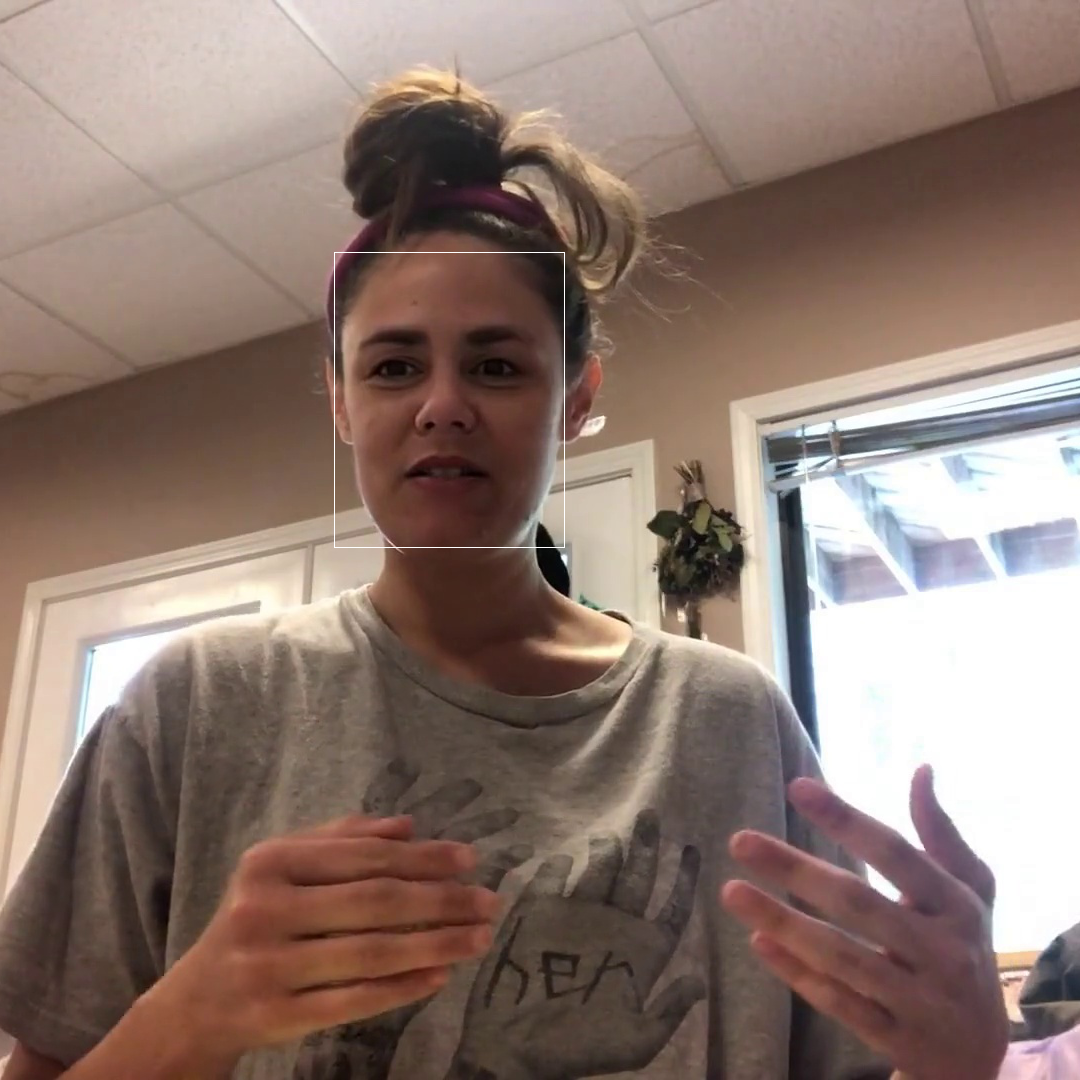

In [18]:
i=0
a=torch.squeeze(torch.chunk(inputs,batch_size)[i])
#a=torchvision.transforms.Normalize([-2.1179,-2.0357,-1.8044],[4.3668,4.4643,4.4444])(a)
tar_image=transforms.ToPILImage(mode='RGB')(a)
bbs=bounding_boxes_list[i]
show_bboxes(tar_image,bbs)

In [19]:
num_empty=0
for i in range(batch_size):
    #print(type(pic))
    a=torch.squeeze(torch.chunk(inputs,batch_size)[i])
    #print(a)
    #a=torchvision.transforms.Normalize([-2.1179,-2.0357,-1.8044],[4.3668,4.4643,4.4444])(a)
    img=transforms.ToPILImage(mode='RGB')(a)
    #img.save(os.path.join("/data2/pbw_dfdc/discrete/",class_names[classes[i]],str(i)+".jpg"))#TODO class
    #width, height = image.size
    #print(class_names[classes[i]])
    #img=image
    bounding_boxes=list_9[i]
    landmarks=list_10[i]
    #print(landmarks)
    show_bboxes(img,bounding_boxes)
    print("yes")
    if len(bounding_boxes):
        bb=bounding_boxes[0]
        #print(bb)
        w1=bb[0]
        h1=bb[1]
        w2=bb[2]
        h2=bb[3]
        aa=[]
        w3=w1-0.1*(w2-w1)
        h3=h1-0.2*(h2-h1)
        w4=w2+0.3*(w2-w1)
        h4=h2+0.2*(h2-h1)
        if (h4-h3)>(w4-w3):
            w3-=0.5*((h4-h3)-(w4-w3))
            w4+=0.5*((h4-h3)-(w4-w3))
        if (h4-h3)>(w4-w3):
            w3-=0.5*((h4-h3)-(w4-w3))
            w4+=0.5*((h4-h3)-(w4-w3))
        if (h4-h3)>(w4-w3):
            w3-=0.5*((h4-h3)-(w4-w3))
            w4+=0.5*((h4-h3)-(w4-w3))
        if w3<0:
            w3=0        
        if h3<0:
            h3=0        
        if w4>img.size[0]:
            w4=img.size[0]
        if h4>img.size[1]:
            h4=img.size[1]
        aa.append(w3)
        aa.append(h3)
        aa.append(w4)
        aa.append(h4)
        #print(aa)
        face=img.crop(aa[:4])
        #face.show()
        face.save(os.path.join("/data2/pbw_dfdc/discrete/",class_names[classes[i]],str(i)+".jpg"))#TODO class
        #print("saved")
    else:
        num_empty+=1
        #print("bounding_boxes is empty!")

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [20]:
# # test
# img=Image.open("/data2/pbw_dfdc/experiment_1/discrete/train/FAKE/pic_0/aaqaifqrwn_jpg/5.jpg")
# img=torchvision.transforms.CenterCrop(1080)(img)
# img=torchvision.transforms.Resize(1080)(img)
# img_tensor=torchvision.transforms.ToTensor()(img)
# print(img_tensor)
# imshow(img_tensor)
# norm_img=torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])(img_tensor)
# print(norm_img)
# imshow(norm_img)
# mean = torch.Tensor([0.485, 0.456, 0.406])
# std = torch.Tensor([0.229, 0.224, 0.225])
# #img_tensor = (img_tensor - mean)/std
# norm_img=torchvision.transforms.Normalize([-2.1179,-2.0357,-1.8044],[4.3668,4.4643,4.4444])(norm_img)
# imshow(norm_img)